
# Explanation of the task:

This is the classic Emotion Recognition Classification task. Given a conversation, involving 2 or more parties, for each message/utterance, we want to predict an emotion related to it.


Consider the example:

**Person A**: "Hello! I am very happy" (happiness)

**Person B**: "Why? I am very angry"   (anger)

## First model idea:
- inputs: sequence of utterances, sequence of emotions.
- For each: Linear Layers
- Fusion model

- Loss: cross-entropy



# Other approach:

Consider the each conversation as just a sequence of words:
$$
[[utt, utt, \cdots], \cdots ] \longrightarrow [[word, word , \cdots], \cdots]
$$

Issue comes when there is some separator: How to implement it? Idea: Use a random token to represent it.

## Weight update:
 - Make the updatable weights constant and then update it dynamically
 - train it once and them update it dynamically in the forward pass
 - cache weight matrices and train them individually -> this does not train properly (super slow convergence)


In [68]:
! pip install nltk
! pip install torch
! pip install pandas
! pip install gensim
! pip install datasets
! pip install matplotlib
! pip install tqdm
! pip install torchinfo

# eventually include tensorboard

In [69]:
# ML resources:
import torch
import os
import matplotlib.pyplot as plt
from datasets import load_dataset
from gensim.models import Word2Vec
from torch.utils.data import Dataset, DataLoader
from collections import Counter

#others:
import pandas as pd
import numpy as np


punctuation = [".",",","?", "!",";",":","-","_","(",")","[","]","{","}"]


## DataLoader not implemented yet:

In [70]:
## annoying to adapt a bit

class DailyDialogDataset(Dataset):
  def __init__(self, text, emot,text_class,emot_class):
  # Dataset object for Daily Dialog dataset
    self.text = text               ## text with embeddings
    self.emot = emot               ## emotion with embeddings
    self.text_class = text_class   ## text for CrossEntropy
    self.emot_class = emot_class   ## emotions for CrossEntropy

  def __len__(self):
    return len(self.text)

  def __getitem__(self, idx):
    item = {
        'text': self.text[idx],
        'emot': self.emot[idx],
        'text_class': self.text_class[idx],
        'emot_class': self.emot_class[idx]
    }
    return item



Here we will extract the data:

In [71]:
emotions_emb = {}

data = load_dataset('daily_dialog')
X_train = data['train']['dialog']
Y_train = data['train']['emotion']

X_test = data['test']['dialog']
Y_test = data['test']['emotion']

X_val = data['validation']['dialog']
Y_val = data['validation']['emotion']

bagofwords = []
emotions = []

for lx,ly in zip(X_train,Y_train):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_val,Y_val):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_test,Y_test):
  assert(len(lx) == len(ly))

While dataloader is not implemented, we have this:

In [72]:
def Preprocess_Data(X_,Y_): ## We do some simple prepocessing
  bagofwords = []
  emotions = []
  X = X_
  Y = Y_
  for i in range(len(X)):
    l1 = []
    l2 = []
    for j in range(len(X[i])):
      to_append = X[i][j].lower().split()
      l1.extend(to_append)
      l2.extend([Y[i][j]]*len(to_append))
      bagofwords.append(to_append)
    X[i] = l1
    Y[i] = l2

  for i in range(len(X)): ## remove puncuation
    to_remove = []
    for j in range(len(X[i])):
      if X[i][j] in punctuation:
        to_remove.append(j)
    for j in to_remove[::-1]:
      X[i].pop(j)
      Y[i].pop(j)
  for i in Y:
    for j in i:
      emotions.append(j)
  emotions = list(set(emotions))

  for lx,ly in zip(X,Y):
    assert(len(lx) == len(ly))
  return X_, Y_, bagofwords, emotions

X_train,Y_train, bagofwords1, emotions = Preprocess_Data(X_train,Y_train)
X_test,Y_test, bagofwords2, _ = Preprocess_Data(X_test,Y_test)
X_val,Y_val, bagofwords3, _ = Preprocess_Data(X_val,Y_val)



In [73]:
for lx,ly in zip(X_train,Y_train):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_val,Y_val):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_test,Y_test):
  assert(len(lx) == len(ly))

print("train size: ",len(X_train))
print("test size: ",len(X_test))
print("validation size: ",len(X_val))
print("emotions: ",emotions)


train size:  11118
test size:  1000
validation size:  1000
emotions:  [0, 1, 2, 3, 4, 5, 6]


Now we train w2v:

In [74]:
word_dim = 800
w2v = Word2Vec(sentences=bagofwords1, vector_size=word_dim, min_count=1)

print("vocabulary size: ",len(w2v.wv))

vocabulary size:  22075


In [75]:
if len(emotions_emb) > 0:
    pass
else:
  emotions_emb = {}

## this continues the preprocess: We get the encoding for each word in the dataset:
def encode_text(X):
  train_X = []
  words_list = []
  train_X_class = {}
  for dialog in X:
    for word in dialog:
      if word not in words_list:
        words_list.append(word)
      try:
        tens = torch.from_numpy(w2v.wv[word])
        tens = tens.type(torch.float32)
      except:
        tens = torch.rand(word_dim,dtype=torch.float32)
      train_X.append(tens)
  stoi = {word:i for i,word in enumerate(words_list)}
  itos = {i:word for i,word in enumerate(words_list)}
  X_utt = []
  for i,word in itos.items():
    tens = torch.zeros(len(words_list))
    tens[i] = 1
    train_X_class[word] = tens
  for dialog in X:
    for word in dialog:
      X_utt.append(stoi[word])
  return train_X, stoi, itos, train_X_class,X_utt

## We do something similar to the emotions (but we initialized them randomly)
def encode_emotions(Y,emotions_emb,plot_=False):
  train_Y = []
  Y_emo = []
  plot_data = {i:0 for i in emotions}
  if len(emotions_emb) == 0:
    for emotion in emotions:
      emotions_emb[emotion] = torch.rand(word_dim,dtype=torch.float32) ## sabe the embeddings of each word
  for dialog in Y:
    for em in dialog:
      train_Y.append(emotions_emb[em])
      Y_emo.append(em)
    if plot_:
      plot_data[em] += 1
  return train_Y, Y_emo

X_train1, stoi_train1, itos_train1, train_X_class,X_train_utt = encode_text(X_train)
Y_train1, Y_train_emo = encode_emotions(Y_train,emotions_emb)

X_test1, _, _, test_X_class,  X_test_utt  = encode_text(X_test)
Y_test1, Y_test_emo = encode_emotions(Y_test,emotions_emb)

X_val1, _, _, val_X_class, X_val_utt = encode_text(X_val)
Y_val1, Y_val_emo= encode_emotions(Y_val,emotions_emb)



In [76]:
for i, vec in enumerate(train_X_class.values()):
  assert(i == torch.argmax(vec))

batch_size = 800
train_data = DailyDialogDataset(X_train1[:-1],Y_train1[:-1],X_train_utt[1:],Y_train_emo[1:])
test_data = DailyDialogDataset(X_test1[:-1],Y_test1[:-1],X_test_utt[1:],Y_test_emo[1:])
val_data = DailyDialogDataset(X_val1[:-1],Y_val1[:-1],X_val_utt[1:],Y_val_emo[1:])

train_loader = DataLoader(train_data, batch_size=batch_size,shuffle = True)
test_loader = DataLoader(test_data, batch_size=batch_size,shuffle = True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle = True)


# The model:
## archtecture
- 2 input channels: word encoding, emotion encoding
- dinamically updated weights: $w_1, w_2 = w1 + w2, w1$ (this is a lie. The weights are cached and trained)
### For each channel:
   - 3 sequential Linear layers
- fusion linear layer through concatenation
- 2 output channels which contain a linear layer each





In [77]:
import torch.nn as nn
import torch.nn.functional as F
class SimpleModel(nn.Module):
  def __init__(self, n_emb_utt, n_emb_emo, emotions_size, vocab_size):
    super(SimpleModel,self).__init__()
    ## Decide size later!
    self.decoder = nn.Linear(n_emb_utt,vocab_size)
    ## Channel for utterances/words:
    self.Linear_utt1 = nn.Linear(n_emb_utt,80)
    self.Linear_utt2 = nn.Linear(80,80)
    self.Linear_utt3 = nn.Linear(80,80)
    self.Linear_utt3.requires_grad = False

    ## Channel for emotions:
    self.Linear_emo1 = nn.Linear(n_emb_utt,80)
    self.Linear_emo2 = nn.Linear(80,80)
    self.Linear_emo3 = nn.Linear(80,80)
    self.Linear_emo3.requires_grad = False

    ## fusion by concatenation and Linear layer:
    self.Linear_fus = nn.Linear(160,300)

    ## We concatenate and do linear again (2 different concatenations)
    self.Linear_utt_final = nn.Linear(380, n_emb_utt)
    self.Linear_emo_final = nn.Linear(380, emotions_size)

    self.softmax = nn.Softmax(dim=0)



  def forward(self, text_emb, emo_emb):

    x = self.Linear_utt1(text_emb)
    x = self.Linear_utt2(x)
    x = self.Linear_utt3(x)

    y = self.Linear_emo1(emo_emb)
    y = self.Linear_emo2(y)
    y = self.Linear_emo3(y)

    z = torch.cat((x,y),-1) ## very simple
    z = self.Linear_fus(z)

    w = torch.cat((z,x),-1)

    pred_token = self.Linear_utt_final(w)
    pred_token = self.decoder(pred_token)
    pred_token = self.softmax(pred_token)

    v = torch.cat((z,y),-1)
    v = self.Linear_emo_final(v)

    pred_emotion = self.softmax(v)
    return pred_token, pred_emotion



In [78]:
import torch.optim as optim
from tqdm.notebook import tqdm
def activate_gpu(force_cpu=False): # check if gpu available ; code taken from template
    device = "cpu"
    if not force_cpu:
        if torch.cuda.is_available(): # for both Nvidia and AMD GPUs
            device = 'cuda'
            print('DEVICE = ', torch.cuda.get_device_name(0))
        elif torch.backends.mps.is_available(): # for mac ARM chipset
            device = 'mps'
            print('DEVICE = ', "mps" )
        else: # for cpu only
            device = 'cpu'
            print('DEVICE = ', 'CPU', "blue")
    return device

## normal train function
def train(model, epochs, device):
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.CrossEntropyLoss()
  model.train()
  model = model.to(device)
  loss = 0
  loss_to_plot = []
  for epoch in range(epochs):
    losses = []
    print(f"Epoch {epoch+1}/{epochs}")
    loss_batch = 0
    for it, batch in tqdm(enumerate(train_loader),total = train_loader.__len__()):
      batch = {'text': batch['text'].to(device), 'emot': batch['emot'].to(device), 'text_class': batch['text_class'].to(device), 'emot_class': batch['emot_class'].to(device)}
      optimizer.zero_grad()
      pt, pe  = model.forward(batch['text'],batch['emot'])
      loss = loss_fn(pe,batch['emot_class'])
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
    loss_to_append = sum(losses)/len(losses)
    loss_to_plot.append(loss_to_append)
    print(f"loss: ",loss_to_append)
  return loss_to_plot


In [79]:
device = activate_gpu()
fn = nn.CrossEntropyLoss()
model = SimpleModel(word_dim,word_dim,len(emotions),len(train_X_class))
print(device)

DEVICE =  CPU blue
cpu


Epoch 1/2


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9391838020557979
Epoch 2/2


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9412817917853522


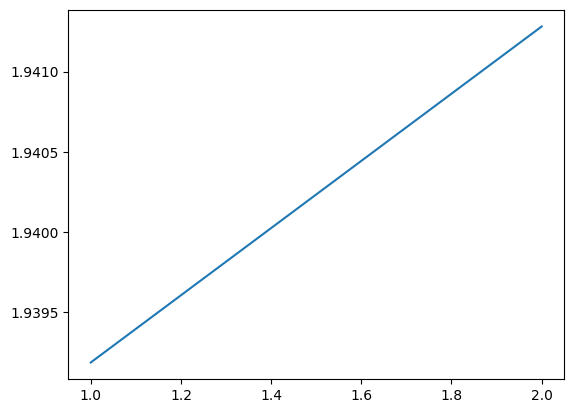

In [80]:
epochs = 2

losses = train(model,epochs,device)
plt.plot(np.arange(1,epochs+1),losses)

# Descrition of the issues faced:

It is not trivial of how to deal with the gradient flow in this case. Maybe by fixing the 2 matrix it would go better. Or just train the matrix with fixed weight. And update the weight not in the forward pass. but in the prediction. this way we can cache the weight and everytime we restart, we will be ok.

I believe that, the issue of this approach specifically is updating directly the weights, and not, a hidden state, for instance.

# Problem with Daily Dialog:
By plotting the frequency of each emotion, we notice that the dataset is truly not diversified. It has essentially only 2 emotions. This is not ideal, because the models will most likely overfit into predicting those 2 emotions...

In [81]:
def compute_test_loss(model,loss_fn,data_loader,device):
  model.eval()
  losses = []
  accs = []
  preds = []
  prec = 0
  trues = []
  for it,batch in tqdm(enumerate(data_loader),total=data_loader.__len__()):
    batch = {'text' : batch['text'].to(device),'emot': batch['emot'].to(device),'text_class': batch['text_class'].to(device),'emot_class': batch['emot_class'].to(device)}
    pt, pe  = model.forward(batch['text'],batch['emot'])
    loss = loss_fn(pe,batch['emot_class'])
    index_pred = torch.argmax(pe,1)
    correct = (batch['emot_class'].flatten() == index_pred.flatten()).float().sum()
    acc = correct/len(index_pred.flatten())
    accs.append(acc.item())
    losses.append(loss.item())
    trues.extend(batch['emot_class'].flatten().tolist())
    preds.extend(index_pred.tolist())
  print("average loss: ", sum(losses)/len(losses))
  print("average acc: ", sum(accs)/len(accs))
  return trues, preds
trues, preds = compute_test_loss(model,nn.CrossEntropyLoss(),val_loader,device)
names = [f'i' for i in range(1,8)]



  0%|          | 0/115 [00:00<?, ?it/s]

average loss:  1.941661022020423
average acc:  0.24201935218728107


In [82]:
print(trues[:100])
print(preds[:100])
names = [f'{i}' for i in range(0,7)]

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))
confusion_matrix(trues,preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 5, 0]
[2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 5, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 3, 2]
              precision    recall  f1-score   support

           0       0.77      0.24      0.36     82011
           1       0.92      0.80      0.85      1083
           2       0.00      0.07      0.00        41
           3       0.24      0.55      0.33       126
           4       0.00      0.00      0.00      6231
           5       0.93      0.75      0.83      1085
           6       

array([[19483,    51, 62294,    23,    19,    49,    92],
       [    5,   861,    58,     1,   156,     1,     1],
       [    0,    19,     3,     5,    14,     0,     0],
       [    0,     0,    10,    69,    47,     0,     0],
       [ 5759,     0,   460,     0,     1,     4,     7],
       [    5,     3,    66,   191,     0,   817,     3],
       [   12,     1,    87,     0,     0,     3,   930]])

In [83]:
def eval_sentence(model, sentence, encoded_sentence, emotions, device):
  model.eval()
  for i in range(len(sentence) - 1):
    pe, _ = model.forward(encoded_sentence[i].to(device),emotions[i].to(device))
    t = torch.max(pe,1)
    print(f"word:{sentence[i+1]}; predicted_emotion: {t} ; target_emotion: {emotions[i+1]}")

# eval_sentence(model,sentence,encod,emot,device)